In [2]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mplhep as hep
from comet_ml import Experiment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score

plt.style.use(hep.style.CMS)


In [3]:
folder = "C:/Users/phili/Desktop/Studium/6. Semester/Semesterarbeit/dataset"

df_target = ak.from_parquet(folder+'/ttHTobb_2018_test.parquet')
df_eft_tbarlnutqq = ak.from_parquet(folder+'/ttHTobb_EFT_tbarlnutqq_2018_test.parquet')
df_eft_tbarqqtlnu = ak.from_parquet(folder+'/ttHTobb_EFT_tbarqqtlnu_2018_test.parquet')

df_eft = ak.concatenate([df_eft_tbarlnutqq, df_eft_tbarqqtlnu])

def reweight(weights_eft, weights_target):
    weights_eft.to_numpy(); weights_target.to_numpy()
    
    A = np.sum(weights_target)/np.sum(weights_eft)
        
    return A, A*weights_eft

weights_eft = df_eft.weight
weights_target = df_target.weight

A, rw_weights_eft = reweight(weights_eft, weights_target)
df_eft = ak.with_field(df_eft, rw_weights_eft, "weight")


print("K-factor: ", A)
"""
plt.hist(rw_weights_eft, bins=100, label="Reweighted weights EFT")
plt.hist(weights_target, bins=100, label="Reweighted weights Target")
plt.legend()
plt.show()
"""

K-factor:  0.7826885718054716


'\nplt.hist(rw_weights_eft, bins=100, label="Reweighted weights EFT")\nplt.hist(weights_target, bins=100, label="Reweighted weights Target")\nplt.legend()\nplt.show()\n'

In [4]:
# Prepare the data for training

# Label them
df_target['label'] = 1
df_eft['label'] = 0

# Concatenate them into one dataset
df_combined = ak.concatenate([df_target, df_eft])

# Example feature list:
objects = ['top', 'antitop', 'lepton_gen', 'lepton_reco', 'higgs']
fields = ['pt', 'eta', 'phi']
orders = [0]
length_features = len(objects)*len(fields)*len(orders)

X = []
for obj in objects:
    for field in fields:
        for order in orders:
            X.append(getattr(getattr(df_combined, obj), field)[:,order])
X = np.stack(X, axis=1) 

y = df_combined.label  
weights_mc = df_combined.weight  

# Convert to Torch tensors
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)
w_torch = torch.tensor(weights_mc, dtype=torch.float32)

In [5]:
# Initialize a Comet experiment
experiment = Experiment(
    api_key="s0G6qTP8E4YpcrewlNfry98cY",
    project_name="ttHbb-reweighting",
    workspace="philiw"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/philiw/tthbb-reweighting/48b41800465443e18e4937d321e34111



COMET INFO: Couldn't find a Git repository in 'c:\\Users\\phili\\Desktop\\Studium\\6. Semester\\Semesterarbeit\\Binary_Classifier_Reweighting' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


In [6]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)  # Output = 1 dimension (logit)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # No activation on the last layer, we'll apply sigmoid in the loss
        return self.fc_out(x)

In [7]:
n_epochs = 5  # adjust as needed
hidden_dim = 64  # hidden layer size
batch_size = 1024  # adjust as needed
learning_rate = 1e-3  # adjust as needed

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Log hyperparameters
experiment.log_parameters({
    "input_dim": length_features,
    "hidden_dim": hidden_dim,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "n_epochs": n_epochs
})

"""
# Build Torch dataset and dataloader
dataset = TensorDataset(X_torch, y_torch, w_torch)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

model = SimpleClassifier(input_dim=length_features, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce_loss = nn.BCEWithLogitsLoss(reduction='none')  # We'll do weighting manually
"""

Using device: cuda


"\n# Build Torch dataset and dataloader\ndataset = TensorDataset(X_torch, y_torch, w_torch)\nloader = DataLoader(dataset, batch_size=1024, shuffle=True)\n\nmodel = SimpleClassifier(input_dim=length_features, hidden_dim=64)\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\nbce_loss = nn.BCEWithLogitsLoss(reduction='none')  # We'll do weighting manually\n"

In [ ]:
def train_model(model, loss_function, loader, optimizer, n_epochs):
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y, batch_w in loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_w = batch_w.to(device)
            optimizer.zero_grad()
            logits = model(batch_x)  # shape: [batch_size, 1]
            # BCE loss with optional event weight
            raw_loss = loss_function(logits.squeeze(), batch_y)
            # multiply by MC weights, then average
            loss = (raw_loss * batch_w).mean()
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        print(f"[Epoch {epoch}] average loss = {avg_loss:.7f}")
        experiment.log_metric("average_loss", avg_loss, step=epoch)

        if epoch % 5 == 0:
            # Evaluate the model on the training set every 5 epochs
            f_eft, reweighted_wts = evaluate_model(model)
            do_plots(f_eft, reweighted_wts)

    # Save the model and log it to Comet
    torch.save(model.state_dict(), "simple_classifier.pth")
    experiment.log_model("simple_classifier", "simple_classifier.pth")

    return model

def evaluate_model(model, loader):
    model.eval()

    print(loader)
    x,y,w = 

    # Grab only EFT events from the combined dataset
    EFT_mask = df_combined.label == 0
    X_eft = X_torch[EFT_mask].to(device)
    w_mc_eft = w_torch[EFT_mask].to(device)

    with torch.no_grad():
        logits_eft = model(X_eft).squeeze()
        f_eft = torch.sigmoid(logits_eft)  # f(x)
        w_new = f_eft / (1.0 - f_eft)      # w(x) = f/(1-f)

    # Final reweighted MC weights for EFT:
    reweighted_wts = w_mc_eft * w_new
    
    return f_eft.cpu(), reweighted_wts.cpu()

def plot_dist_f(f_eft):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(f_eft, bins=50)
    ax.set_xlabel("f(x)")
    ax.set_ylabel("Events")
    filename = f"distribution_f_.png"
    plt.savefig(filename)
    experiment.log_image(filename, name=filename)

def plot_1d_dist(reweighted_wts):
    # Loop over each combination
    for obj in objects:
        for field in fields:
            if field == 'pt':
                bins = np.logspace(1.3, 2.9, 50)
                scale='log'
            if field == 'eta':
                bins = np.linspace(-4, 4, 50)
                scale='linear'
            if field == 'phi':
                bins = np.linspace(-np.pi, np.pi, 50)
                scale='linear'
            
            for order in orders:
                # Extract the appropriate variable from the EFT and Target data
                eft_variable = getattr(getattr(df_eft, obj), field)[:, order]
                target_variable = getattr(getattr(df_target, obj), field)[:, order]

                # Define your histogram bins (you may wish to adjust these per variable)
                bin_centers = 0.5 * (bins[1:] + bins[:-1])

                # Compute the histograms
                hist_eft, _    = np.histogram(eft_variable, bins=bins, weights=w_mc_eft.numpy())
                hist_rw_eft, _ = np.histogram(eft_variable, bins=bins, weights=reweighted_wts.numpy())
                hist_target, _ = np.histogram(target_variable, bins=bins, weights=weights_target)

                # Create the figure with a top and bottom panel
                fig, (ax_top, ax_bot) = plt.subplots(
                    2, 1, figsize=(10, 10),
                    gridspec_kw={'height_ratios': [5, 2]}
                )

                # Top panel: draw the histograms
                ax_top.stairs(hist_eft, bins, label="EFT data (unweighted)", fill=False)
                ax_top.stairs(hist_rw_eft, bins, label=f"Reweighted EFT ({order})", fill=False)
                ax_top.stairs(hist_target, bins, label="Target data", fill=False)
                ax_top.set_xscale(scale)
                ax_top.set_xlabel(f"{obj}.{field}")
                ax_top.set_ylabel("Weighted events")
                ax_top.set_title(f"Histogram of {obj}.{field}\n(reweighting: {order})")
                ax_top.legend()

                # Bottom panel: compute and plot the ratios
                # Ratio of target to original EFT
                ratio_old = np.where(hist_eft != 0, hist_target / hist_eft, np.nan)
                # Ratio of target to reweighted EFT
                ratio_rw = np.where(hist_rw_eft != 0, hist_target / hist_rw_eft, np.nan)

                ax_bot.plot(bin_centers, ratio_old, 'o-', label="Original ratio", markersize=3)
                ax_bot.plot(bin_centers, ratio_rw, 'o-', label=f"Reweighted ratio ({order})", markersize=3)
                ax_bot.set_xscale(scale)
                ax_bot.axhline(1.0, color='gray', linestyle='--')
                ax_bot.set_ylim(0.5, 1.5)
                ax_bot.set_ylabel("Target / EFT")
                ax_bot.set_xlabel(f"{obj}.{field}")
                ax_bot.legend(fontsize=10)

                plt.tight_layout()

                # Save and log the figure
                filename = f"reweighting_plot_{obj}_{field}_{order}.png"
                experiment.log_image(filename, name=filename)

                # Close the plot to free up memory before the next loop iteration
                plt.close(fig)

def do_plots(f_eft, reweighted_wts):
    # Plot the distribution of f(x)
    plot_dist_f(f_eft)

    # Plot the 1D distributions
    plot_1d_dist(reweighted_wts)

def pipeline(
    X_tensor, y_tensor, w_tensor,
    df_combined, df_eft, df_target,
    model_class,
    input_dim,
    k=5,
    n_epochs=20,
    batch_size=32,
    device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
):
    """
    Run your full train → eval → plot pipeline in k folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    all_metrics = {'accuracy': [], 'auc': []}

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor), 1):
        print(f"\n=== Fold {fold}/{k} ===")

        # 1) build loaders for this fold
        train_ds = TensorDataset(
            X_tensor[train_idx], y_tensor[train_idx], w_tensor[train_idx]
        )
        val_ds   = TensorDataset(
            X_tensor[val_idx],   y_tensor[val_idx],   w_tensor[val_idx]
        )
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=batch_size)

        # 2) new model & optimizer
        model     = model_class(input_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        
        # 3) train (this still logs loss each epoch, does your every-5-epoch evaluate+plot)
        train_model(model, bce_loss, train_loader, optimizer, n_epochs)

        # 4) final train-set evaluation + plots (unchanged)
        f_eft, reweighted_wts = evaluate_model(model, val_loader)
        do_plots(f_eft, reweighted_wts)

        # 5) compute hold-out fold metrics
        model.eval()
        with torch.no_grad():
            probs = torch.sigmoid(model(X_tensor[val_idx].to(device)).squeeze()).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_val  = y_tensor[val_idx].numpy()
        w_val  = w_tensor[val_idx].numpy()

        acc = accuracy_score(y_val, preds)
        auc = roc_auc_score(y_val, probs, sample_weight=w_val)
        print(f"Fold {fold} → acc={acc:.4f}, auc={auc:.4f}")

        all_metrics['accuracy'].append(acc)
        all_metrics['auc'].append(auc)

    # 6) overall summary
    mean_acc = np.mean(all_metrics['accuracy'])
    mean_auc = np.mean(all_metrics['auc'])
    print(f"\n== CV summary: mean accuracy = {mean_acc:.4f}, mean AUC = {mean_auc:.4f} ==")
    return all_metrics


=== Fold 1/5 ===
[Epoch 0] average loss = 0.0013581


C:\Users\phili\AppData\Local\Temp\ipykernel_7580\911848441.py:40: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_eft = X_torch[EFT_mask].to(device)
C:\Users\phili\AppData\Local\Temp\ipykernel_7580\911848441.py:41: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  w_mc_eft = w_torch[EFT_mask].to(device)


NameError: name 'w_mc_eft' is not defined

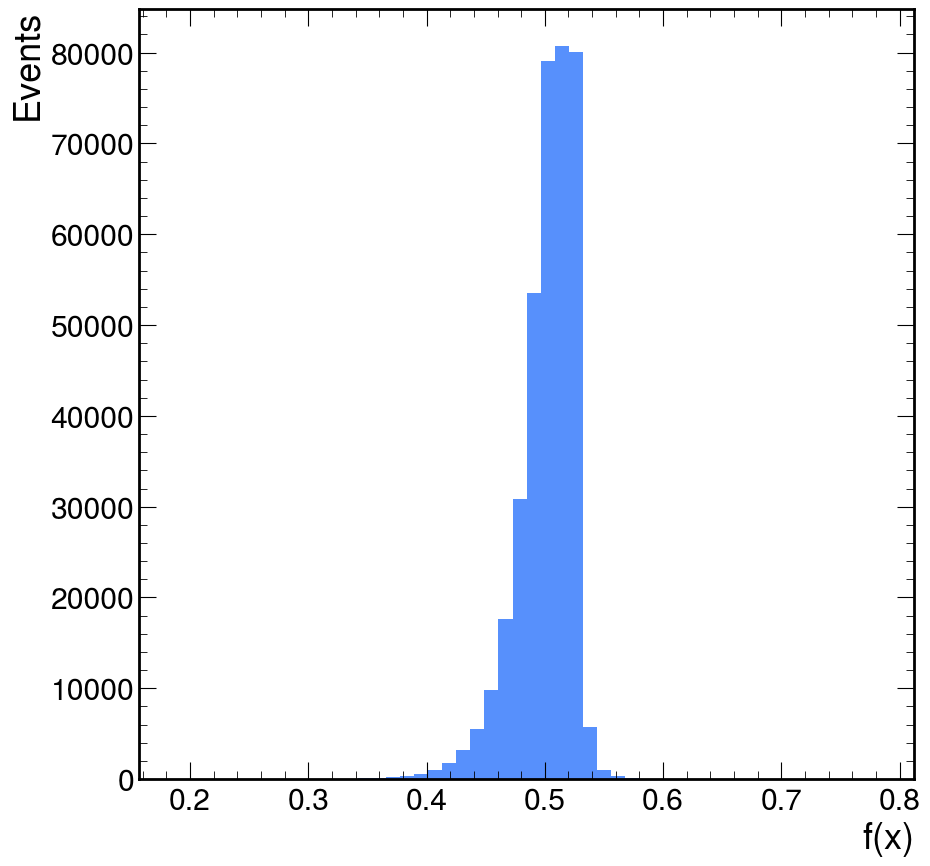

In [11]:
cv_results = pipeline(
    X_torch, y_torch, w_torch,
    df_combined, df_eft, df_target,
    SimpleClassifier,
    input_dim=X_torch.shape[1],
    k=5,
    n_epochs=20,
    batch_size=64,
    device=device
)